In [1]:
# Data taken from covidtracking.com

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from datetime import datetime, timedelta
from ipywidgets import interact
import itertools
from tabulate import tabulate
import plotly.express as px

import statsmodels.formula.api as smf

# Library for diagnostic plots
import diagnosticPlotsForLinearRegression_likeR as dpR

# This is not recommended but I am doing this to suppress warnings from SARIMAX
warnings.simplefilter('ignore')

In [3]:
# Read csv
USDataFilename = os.path.join('data', 'covidtracking', 'latest', 'current.csv')

# This is the name of the old file
# USDataFilename = os.path.join('data', 'covidtracking', 'latest', 'states.csv')
USCovidFr = pd.read_csv(USDataFilename)

# Fill NA in recovered and dead columns with 0 
USCovidFr['recovered'].fillna(0, inplace=True)
USCovidFr['death'].fillna(0, inplace=True)

USCovidFr

,state,positive,positiveScore,negativeScore,negativeRegularScore,commercialScore,grade,score,negative,pending,...,death,hospitalized,total,totalTestResults,posNeg,fips,dateModified,dateChecked,notes,hash
0,AK,257,1.0,1.0,1.0,1.0,A,4.0,7475,NaN,...,8.0,31.0,7732,7732,7732,2,2020-04-11T18:45:00Z,2020-04-11T20:39:00Z,"Please stop using the ""total"" field. Use ""tota...",9a40c45c0a168b48c7e6db4484946abc1dee37bb
1,AL,3262,1.0,1.0,0.0,1.0,B,3.0,18058,NaN,...,93.0,402.0,21320,21320,21320,1,2020-04-11T04:00:00Z,2020-04-12T02:51:00Z,"Please stop using the ""total"" field. Use ""tota...",89141ccadad5aa376d34b633a4a8ec97c66a668b
2,AR,1226,1.0,1.0,1.0,1.0,A,4.0,17352,NaN,...,24.0,130.0,18578,18578,18578,5,2020-04-11T17:20:00Z,2020-04-11T18:38:00Z,"Please stop using the ""total"" field. Use ""tota...",ca8cb0bd47947c73ac07b843155d113ef0bea032
3,AZ,3393,1.0,1.0,0.0,1.0,B,3.0,37137,NaN,...,108.0,NaN,40530,40530,40530,4,2020-04-11T04:00:00Z,2020-04-12T02:52:00Z,"Please stop using the ""total"" field. Use ""tota...",87f13b79fbc8dc86bb701d2b879e38c37371ec55
4,CA,20615,1.0,1.0,0.0,1.0,B,3.0,162371,13200.0,...,609.0,NaN,196186,182986,182986,6,2020-04-10T04:00:00Z,2020-04-12T03:23:00Z,"Please stop using the ""total"" field. Use ""tota...",75c29fc5f48a8f455022e2ae3f6119e0d3f2961a
5,CO,6893,1.0,1.0,1.0,1.0,A,4.0,27980,NaN,...,274.0,1376.0,34873,34873,34873,8,2020-04-11T04:00:00Z,2020-04-12T03:15:00Z,"Please stop using the ""total"" field. Use ""tota...",4e00bda2bc86398712783f6c145a6c79e47c67c9
6,CT,11510,1.0,1.0,1.0,1.0,A,4.0,28321,NaN,...,494.0,NaN,39831,39831,39831,9,2020-04-11T19:30:00Z,2020-04-11T20:01:00Z,"Please stop using the ""total"" field. Use ""tota...",5883a34dc816d7f1991b43ee71d2f41a31d64512
7,DC,1778,1.0,1.0,1.0,1.0,A,4.0,8261,NaN,...,47.0,NaN,10039,10039,10039,11,2020-04-10T14:00:00Z,2020-04-12T03:01:00Z,"Please stop using the ""total"" field. Use ""tota...",315233f3cb9b3c852fd25bea3559ebed870be60a
8,DE,1479,1.0,1.0,1.0,1.0,A,4.0,9624,NaN,...,33.0,NaN,11103,11103,11103,10,2020-04-11T17:30:00Z,2020-04-11T20:42:00Z,"Please stop using the ""total"" field. Use ""tota...",42e43803eda67672eac50f30cd60c8390f0d04cb
9,FL,18986,1.0,1.0,1.0,1.0,A,4.0,156532,1345.0,...,458.0,2744.0,176863,175518,175518,12,2020-04-11T22:30:00Z,2020-04-12T03:33:00Z,"Please stop using the ""total"" field. Use ""tota...",5a2d39724e45a3392bc6586b55c016b9183fa249


In [4]:
# Look at columns
list(USCovidFr.columns)

['state',
 'positive',
 'positiveScore',
 'negativeScore',
 'negativeRegularScore',
 'commercialScore',
 'grade',
 'score',
 'negative',
 'pending',
 'hospitalizedCurrently',
 'hospitalizedCumulative',
 'inIcuCurrently',
 'inIcuCumulative',
 'onVentilatorCurrently',
 'onVentilatorCumulative',
 'recovered',
 'lastUpdateEt',
 'checkTimeEt',
 'death',
 'hospitalized',
 'total',
 'totalTestResults',
 'posNeg',
 'fips',
 'dateModified',
 'dateChecked',
 'notes',
 'hash']

In [5]:
# Get closed cases ('death' + 'recovered')
USCovidFr['closed'] = USCovidFr['death'] + USCovidFr['recovered']

# Get open cases ('positive' - 'closed')
USCovidFr['open'] = USCovidFr['positive'] - USCovidFr['closed']

                            OLS Regression Results                            
Dep. Variable:           hospitalized   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3183.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           1.01e-28
Time:                        20:37:35   Log-Likelihood:                -216.34
No. Observations:                  28   AIC:                             436.7
Df Residuals:                      26   BIC:                             439.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -90.9366    112.885     -0.806      0.4

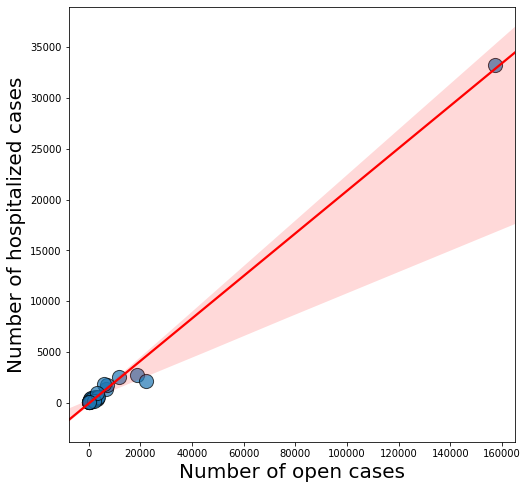

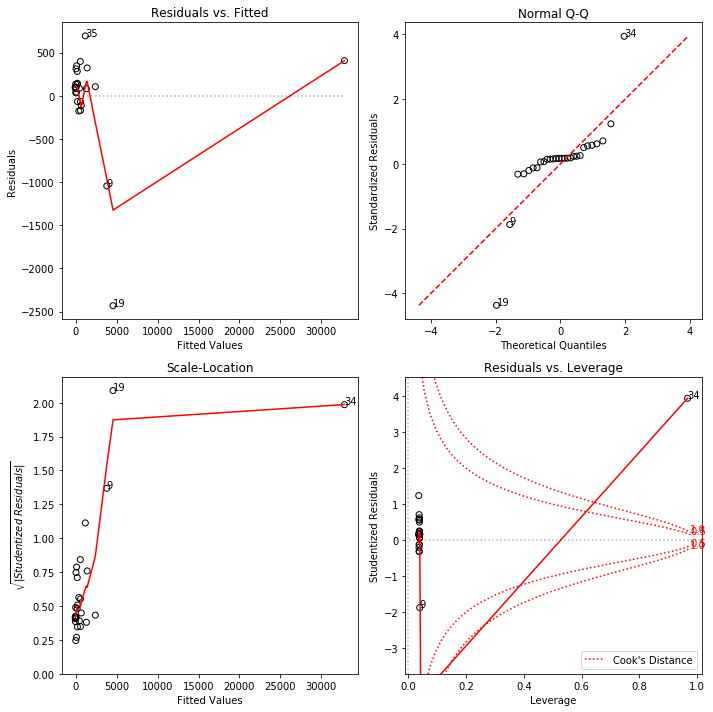

In [6]:
# Plot hospitalization vs. open cases
# Remove NA from hospitalized and open column
USCovidCorrectedFr = USCovidFr.dropna(subset=['hospitalized', 'open'])
plt.figure(figsize=(8,8))
sns.regplot(x="open",
            y="hospitalized",
            data=USCovidCorrectedFr,
            scatter_kws={'alpha':0.7,
                         'edgecolor':'k',
                         's':200},
            line_kws={'color':'red'});
plt.xlabel("Number of open cases", fontsize=20);
plt.ylabel("Number of hospitalized cases", fontsize=20);

# Check using metrics and diagnostic plots
model = smf.ols(formula='hospitalized ~ open', data=USCovidCorrectedFr)
results = model.fit()
print(results.summary())

dpR.all4DiagnosticPlots(results)

In [7]:
# Look out for Row 34 - NY
USCovidFr.loc[34,]['state']

'NY'

                            OLS Regression Results                            
Dep. Variable:           hospitalized   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     101.5
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           2.75e-10
Time:                        20:37:38   Log-Likelihood:                -196.82
No. Observations:                  27   AIC:                             397.6
Df Residuals:                      25   BIC:                             400.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    182.7791     85.732      2.132      0.0

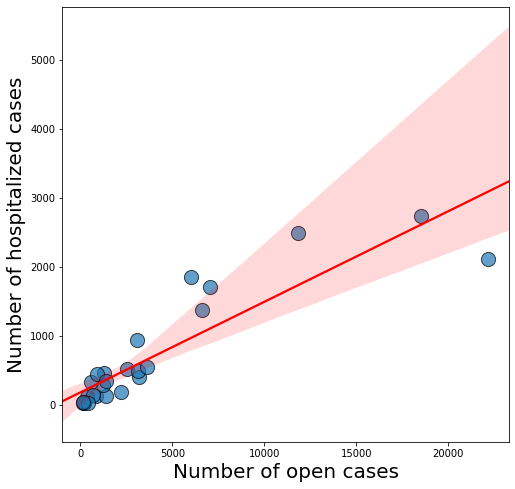

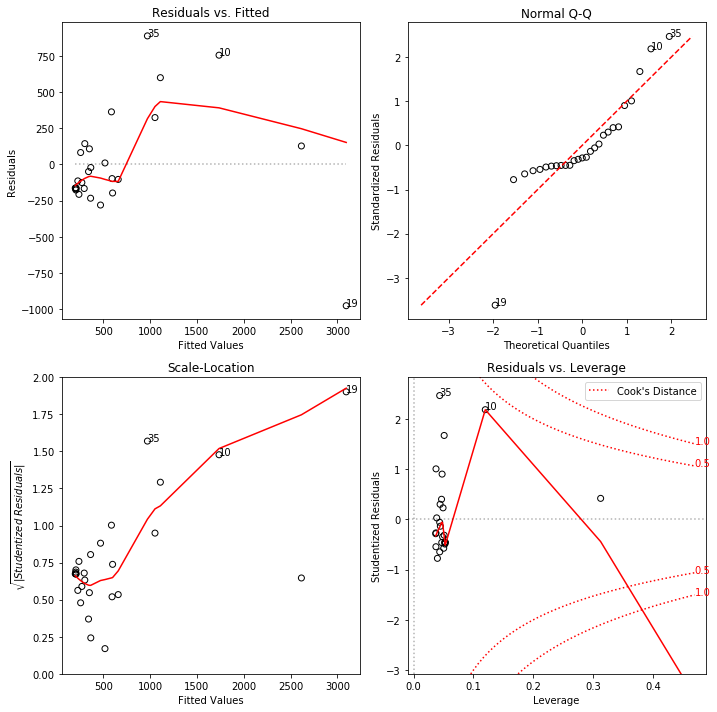

In [8]:
# Plot hospitalization vs. open cases except NY
USCovidWithoutNYFr = USCovidCorrectedFr[USCovidCorrectedFr['state'] != 'NY']
plt.figure(figsize=(8,8))
sns.regplot(x="open",
            y="hospitalized",
            data=USCovidWithoutNYFr,
            scatter_kws={'alpha':0.7,
                         'edgecolor':'k',
                         's':200},
            line_kws={'color':'red'});
plt.xlabel("Number of open cases", fontsize=20);
plt.ylabel("Number of hospitalized cases", fontsize=20);

# Check using metrics and diagnostic plots
model = smf.ols(formula='hospitalized ~ open', data=USCovidWithoutNYFr)
results = model.fit()
print(results.summary())
dpR.all4DiagnosticPlots(results)

In [9]:
# Row 20 looks like an outlier - MD actually
USCovidWithoutNYFr.loc[20,]

state                                                                    MD
positive                                                               7694
positiveScore                                                             1
negativeScore                                                             1
negativeRegularScore                                                      1
commercialScore                                                           1
grade                                                                     A
score                                                                     4
negative                                                              39544
pending                                                                 NaN
hospitalizedCurrently                                                   NaN
hospitalizedCumulative                                                 1709
inIcuCurrently                                                          NaN
inIcuCumulat

                            OLS Regression Results                            
Dep. Variable:           hospitalized   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     103.8
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           3.41e-10
Time:                        20:37:40   Log-Likelihood:                -188.48
No. Observations:                  26   AIC:                             381.0
Df Residuals:                      24   BIC:                             383.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    169.2092     82.843      2.043      0.0

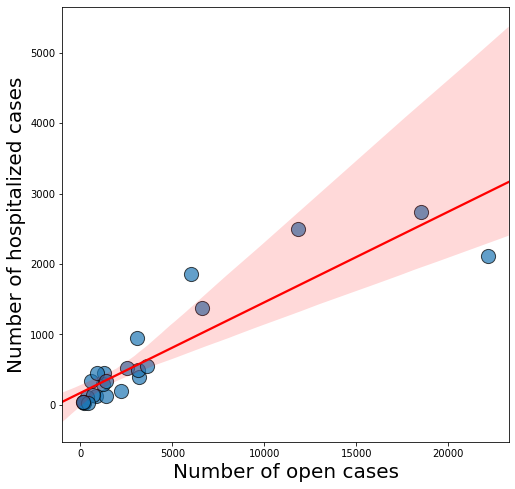

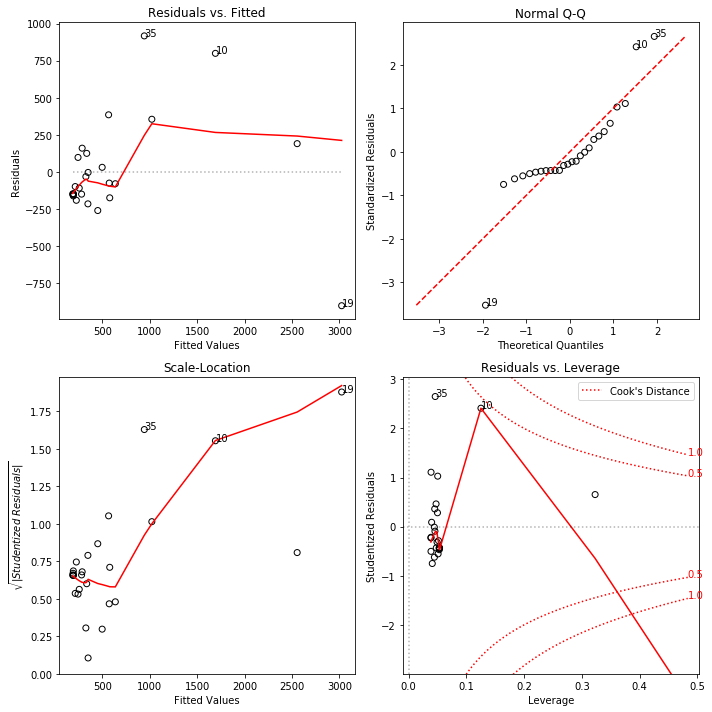

In [10]:
# Remove MD and re-do regression
USCovidWithoutNYAndMDFr = USCovidWithoutNYFr[USCovidWithoutNYFr['state'] != 'MD']

# Plot hospitalization vs. open cases except NY and MD
plt.figure(figsize=(8,8))
sns.regplot(x="open",
            y="hospitalized",
            data=USCovidWithoutNYAndMDFr,
            scatter_kws={'alpha':0.7,
                         'edgecolor':'k',
                         's':200},
            line_kws={'color':'red'});
plt.xlabel("Number of open cases", fontsize=20);
plt.ylabel("Number of hospitalized cases", fontsize=20);

# Check using metrics and diagnostic plots
model = smf.ols(formula='hospitalized ~ open', data=USCovidWithoutNYAndMDFr)
results = model.fit()
print(results.summary())
dpR.all4DiagnosticPlots(results)

In [11]:
print(results.params)

Intercept    169.209203
open           0.128691
dtype: float64


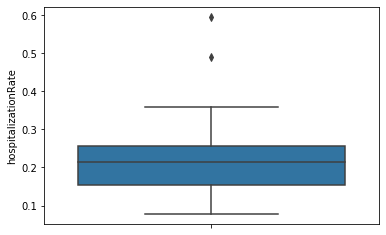

In [13]:
# Get hospitalization rates
USCovidFr['hospitalizationRate'] = USCovidFr['hospitalized']/USCovidFr['open']
sns.boxplot(y='hospitalizationRate',
            data=USCovidFr)

                              OLS Regression Results                             
Dep. Variable:     onVentilatorCurrently   R-squared:                       1.000
Model:                               OLS   Adj. R-squared:                    nan
Method:                    Least Squares   F-statistic:                     0.000
Date:                   Sun, 12 Apr 2020   Prob (F-statistic):                nan
Time:                           20:45:05   Log-Likelihood:                 61.402
No. Observations:                      2   AIC:                            -118.8
Df Residuals:                          0   BIC:                            -121.4
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       23

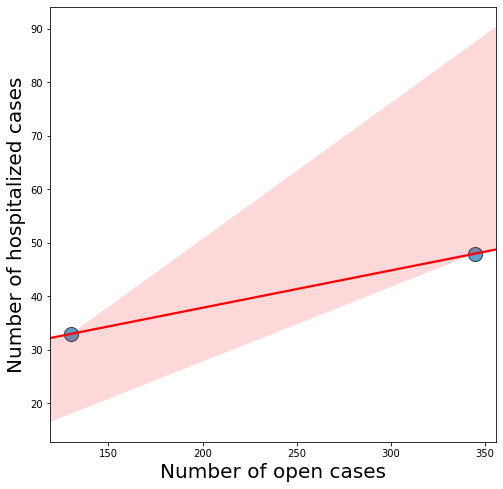

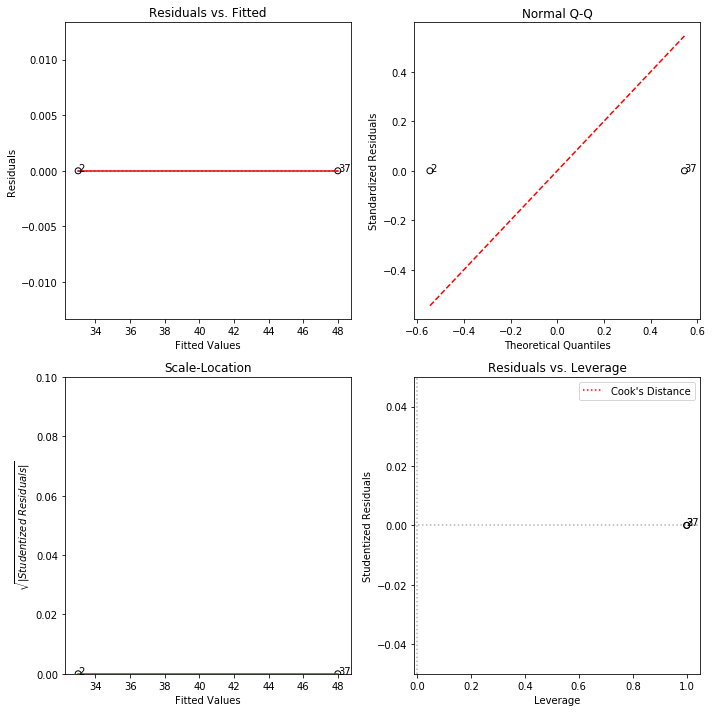

In [15]:
# Look at ventilator data
# Plot ventilator vs. hospitalized cases
# Remove NA from hospitalized and open column
USCovidCorrectedFr = USCovidFr.dropna(subset=['hospitalized', 'onVentilatorCurrently'])
plt.figure(figsize=(8,8))
sns.regplot(x="hospitalized",
            y="onVentilatorCurrently",
            data=USCovidCorrectedFr,
            scatter_kws={'alpha':0.7,
                         'edgecolor':'k',
                         's':200},
            line_kws={'color':'red'});
plt.xlabel("Number of open cases", fontsize=20);
plt.ylabel("Number of hospitalized cases", fontsize=20);

# Check using metrics and diagnostic plots
model = smf.ols(formula='onVentilatorCurrently ~ hospitalized', data=USCovidCorrectedFr)
results = model.fit()
print(results.summary())

dpR.all4DiagnosticPlots(results)

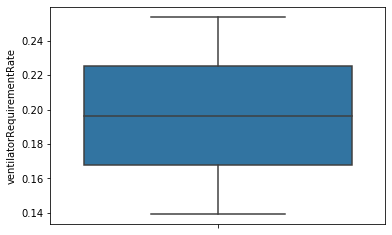

In [16]:
# Get ventilator required rates
USCovidFr['ventilatorRequirementRate'] = USCovidFr['onVentilatorCurrently']/USCovidFr['hospitalized']
sns.boxplot(y='ventilatorRequirementRate',
            data=USCovidFr)